# Análise de Crescimento da Telemedicina por Região e Perfil Demográfico

Este notebook apresenta uma análise exploratória de dados (EDA) e um modelo de Machine Learning
focado em responder à seguinte pergunta:

> É possível prever se uma combinação de características regionais e demográficas
> terá um **crescimento acentuado** no uso de telemedicina em relação ao trimestre anterior?

O conjunto de dados utilizado é o arquivo público `TMEDTREND_PUBLIC_250827.csv`, que traz informações
sobre utilização de telemedicina em beneficiários do Medicare, segmentados por:

- Estado / região geográfica (`Bene_Geo_Desc`)
- Ano e trimestre (`Year`, `quarter`)
- Faixa etária, sexo, raça e status de elegibilidade
- Situação de inscrição em Medicare / Medicaid
- Ruralidade da região (rural / urbana)
- Métricas relacionadas a elegibilidade e uso de telehealth, incluindo `Pct_Telehealth`.

A análise está organizada da seguinte forma:

1. Carregamento e preparação dos dados  
2. Criação das variáveis de **crescimento**  
3. Análise exploratória focada em crescimento  
4. Formulação do problema de Machine Learning  
5. Treinamento e avaliação do modelo de classificação  
6. Interpretação dos resultados e implicações para o contexto de HealthTech.


## 1. Objetivo da análise

O objetivo principal deste trabalho é identificar padrões de crescimento no uso de telemedicina
e verificar se é possível construir um modelo supervisionado capaz de **classificar** regiões
(estado × trimestre × grupo demográfico) entre:

- `HighGrowth = 1` → alto crescimento do uso de telemedicina em relação ao trimestre anterior  
- `HighGrowth = 0` → crescimento baixo, estável ou queda

A partir desses resultados, discutimos como tais insights podem apoiar o **desenho de novos serviços
digitais de saúde**, voltados a bem-estar e prevenção, sem realizar teleconsultas ou diagnósticos,
em alinhamento com as restrições do desafio de HealthTech.


## 2. Carregamento dos dados e bibliotecas

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

pd.set_option("display.max_columns", 50)


### 2.1. Leitura do arquivo

Nesta etapa, carregamos o arquivo CSV original.  
Para reproduzir a análise, coloque o arquivo `TMEDTREND_PUBLIC_250827.csv`
na mesma pasta deste notebook.


In [3]:
# Caminho do arquivo (ajuste se necessário)
csv_path = "TMEDTREND_PUBLIC_250827.csv"

df_raw = pd.read_csv(csv_path)
df_raw.head()

,Year,quarter,Bene_Geo_Desc,Bene_Mdcd_Mdcr_Enrl_Stus,Bene_Race_Desc,Bene_Sex_Desc,Bene_Mdcr_Entlmt_Stus,Bene_Age_Desc,Bene_RUCA_Desc,Total_Bene_TH_Elig,Total_PartB_Enrl,Total_Bene_Telehealth,Pct_Telehealth
0,2020,Overall,National,All,All,All,All,All,All,30946785.0,3.224489e+07,14826919.0,0.4791
1,2020,Overall,National,All,All,All,All,All,Rural,7182616.0,7.493527e+06,2859483.0,0.3981
2,2020,Overall,National,All,All,All,All,All,Urban,23699049.0,2.463142e+07,11945312.0,0.5040
3,2020,Overall,National,All,All,All,All,All,Unknown,NaN,NaN,NaN,NaN
4,2020,Overall,National,All,All,All,All,0-64,All,4088345.0,4.291403e+06,2322324.0,0.5680


### 2.2. Visão geral do conjunto de dados

Aqui inspecionamos o tamanho do dataset, os tipos de dados e a quantidade de valores ausentes.
Essa etapa é importante para orientar os passos de limpeza e preparação.


In [4]:
df_raw.shape, df_raw.dtypes

((31304, 13),
 Year                          int64
 quarter                      object
 Bene_Geo_Desc                object
 Bene_Mdcd_Mdcr_Enrl_Stus     object
 Bene_Race_Desc               object
 Bene_Sex_Desc                object
 Bene_Mdcr_Entlmt_Stus        object
 Bene_Age_Desc                object
 Bene_RUCA_Desc               object
 Total_Bene_TH_Elig          float64
 Total_PartB_Enrl            float64
 Total_Bene_Telehealth       float64
 Pct_Telehealth              float64
 dtype: object)

In [5]:
df_raw.isna().mean().sort_values(ascending=False).head(20)

Pct_Telehealth              0.107878
Total_Bene_Telehealth       0.107814
Total_Bene_TH_Elig          0.105865
Total_PartB_Enrl            0.105865
Year                        0.000000
quarter                     0.000000
Bene_Geo_Desc               0.000000
Bene_Mdcd_Mdcr_Enrl_Stus    0.000000
Bene_Race_Desc              0.000000
Bene_Sex_Desc               0.000000
Bene_Mdcr_Entlmt_Stus       0.000000
Bene_Age_Desc               0.000000
Bene_RUCA_Desc              0.000000
dtype: float64

## 3. Preparação dos dados

Nesta seção realizamos passos básicos de pré-processamento:

1. Remover registros sem informação de `Pct_Telehealth`.  
2. Considerar apenas trimestres **explícitos** (`quarter` = 1, 2, 3, 4), excluindo linhas agregadas como `Overall`.  
3. (Opcional) Excluir agregados nacionais, para focar em estados e territórios.

Essas decisões buscam garantir que a variável alvo de interesse (crescimento de `Pct_Telehealth`)
seja bem definida entre trimestres consecutivos.


In [6]:
df = df_raw.copy()

# 1) Manter apenas linhas com informação de Pct_Telehealth
df = df[df["Pct_Telehealth"].notna()]

# 2) Manter apenas trimestres explícitos (1, 2, 3, 4)
df = df[df["quarter"].isin(["1", "2", "3", "4"])]

# 3) (Opcional) excluir agregado 'National'
if "Bene_Geo_Desc" in df.columns:
    df = df[df["Bene_Geo_Desc"] != "National"]

df.shape

(20321, 13)

## 4. Criação das variáveis de crescimento

Para responder à Pergunta 2, precisamos comparar o uso de telemedicina de um grupo em relação ao
trimestre anterior. Para isso:

1. Definimos um **grupo** como a combinação de:
   - Estado / região (`Bene_Geo_Desc`)
   - Situação de inscrição em Medicare/Medicaid (`Bene_Mdcd_Mdcr_Enrl_Stus`)
   - Raça (`Bene_Race_Desc`)
   - Sexo (`Bene_Sex_Desc`)
   - Faixa etária (`Bene_Age_Desc`)
   - Status de elegibilidade (`Bene_Mdcr_Entlmt_Stus`)
   - Ruralidade (`Bene_RUCA_Desc`)

2. Ordenamos cronologicamente por `Year` e `quarter`.  
3. Calculamos a variação de um trimestre para o outro:

   $$\Delta \text{Pct\_Telehealth} = \text{Pct\_Telehealth}_{t} - \text{Pct\_Telehealth}_{t-1}$$

4. Definimos também `Prev_Pct_Telehealth`, ou seja, o valor de `Pct_Telehealth` no trimestre anterior,
que será uma feature importante do modelo.

5. Por fim, definimos a classe binária `HighGrowth`, considerando **alto crescimento** os casos cujo
$\Delta \text{Pct\_Telehealth}$ é **positivo** e está no **percentil 75** ou acima entre os deltas positivos.


In [20]:
group_cols = [
    "Bene_Geo_Desc",
    "Bene_Mdcd_Mdcr_Enrl_Stus",
    "Bene_Race_Desc",
    "Bene_Sex_Desc",
    "Bene_Mdcr_Entlmt_Stus",
    "Bene_Age_Desc",
    "Bene_RUCA_Desc"
]

# Ordenar por grupo e tempo
df = df.sort_values(group_cols + ["Year", "quarter"])

# Delta de telemedicina e valor anterior
df["Delta_Telehealth"] = df.groupby(group_cols)["Pct_Telehealth"].diff()
df["Prev_Pct_Telehealth"] = df.groupby(group_cols)["Pct_Telehealth"].shift()

# Selecionar apenas deltas positivos para calcular o threshold de "alto crescimento"
positive_deltas = df["Delta_Telehealth"][df["Delta_Telehealth"] > 0].dropna()
p75_delta = positive_deltas.quantile(0.75)

p75_delta

np.float64(0.023299999999999987)

In [21]:
# Criar variável binária HighGrowth
df["HighGrowth"] = (
    (df["Delta_Telehealth"] >= p75_delta) &
    (df["Delta_Telehealth"] > 0)
).astype(int)

# Manter apenas linhas onde o delta está definido (ou seja, não é o primeiro trimestre do grupo)
df_model = df.dropna(subset=["Delta_Telehealth", "Prev_Pct_Telehealth"]).copy()

df_model["HighGrowth"].value_counts(normalize=True)

HighGrowth
0    0.888837
1    0.111163
Name: proportion, dtype: float64

## 5. Análise exploratória focada em crescimento

Com a variável `Delta_Telehealth` e a classe binária `HighGrowth` definidas,
podemos investigar padrões de crescimento por ano, estado e perfis demográficos.

A seguir, analisamos:

- A distribuição de `Delta_Telehealth` (variações entre trimestres).  
- A proporção de casos de alto crescimento ao longo do tempo.  
- Diferenças de crescimento por faixa etária, raça e ruralidade.


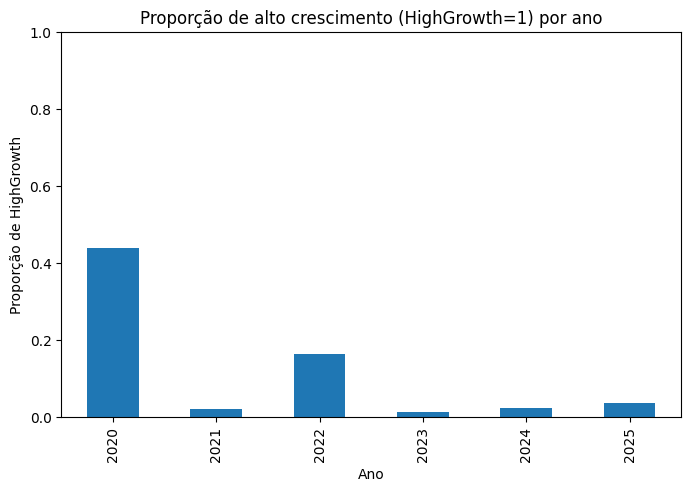

Year
2020    0.437134
2021    0.020619
2022    0.163355
2023    0.012160
2024    0.022792
2025    0.035197
Name: HighGrowth, dtype: float64

In [10]:
# Proporção de HighGrowth por ano
growth_by_year = df_model.groupby("Year")["HighGrowth"].mean()

plt.figure(figsize=(8, 5))
growth_by_year.plot(kind="bar")
plt.title("Proporção de alto crescimento (HighGrowth=1) por ano")
plt.ylabel("Proporção de HighGrowth")
plt.xlabel("Ano")
plt.ylim(0, 1)
plt.show()

growth_by_year

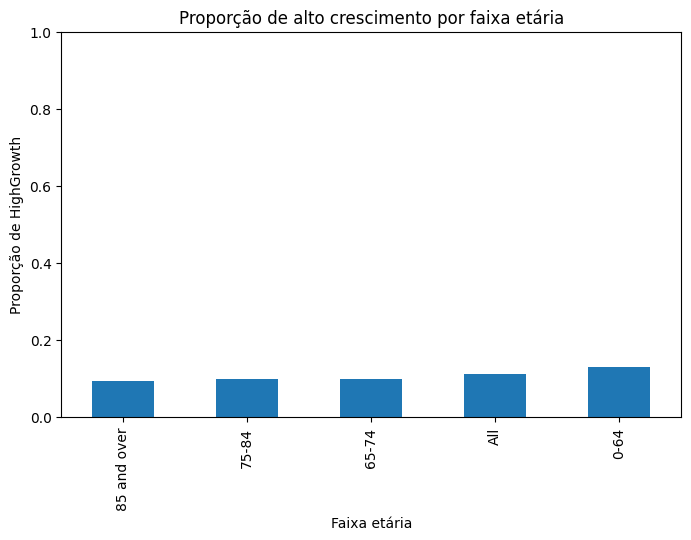

In [11]:
# Proporção de HighGrowth por faixa etária
if "Bene_Age_Desc" in df_model.columns:
    growth_by_age = df_model.groupby("Bene_Age_Desc")["HighGrowth"].mean().sort_values()

    plt.figure(figsize=(8, 5))
    growth_by_age.plot(kind="bar")
    plt.title("Proporção de alto crescimento por faixa etária")
    plt.ylabel("Proporção de HighGrowth")
    plt.xlabel("Faixa etária")
    plt.ylim(0, 1)
    plt.show()

    growth_by_age

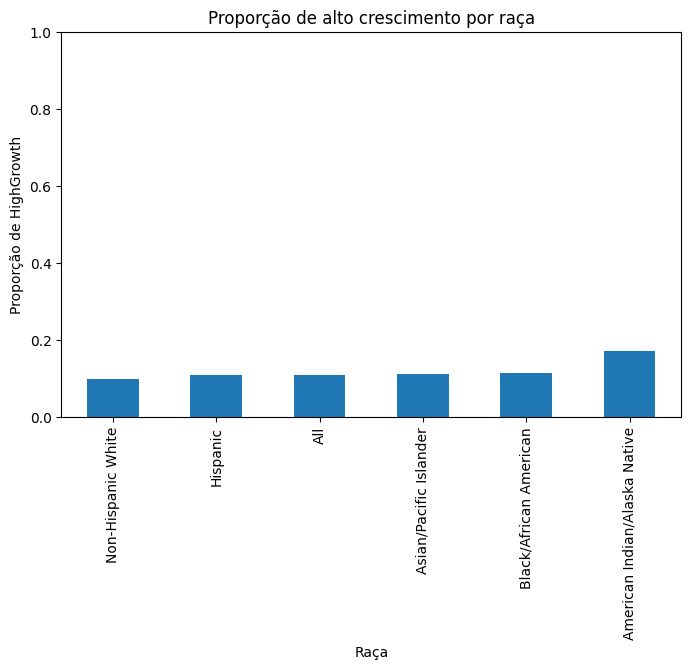

In [12]:
# Proporção de HighGrowth por raça
if "Bene_Race_Desc" in df_model.columns:
    growth_by_race = df_model.groupby("Bene_Race_Desc")["HighGrowth"].mean().sort_values()

    plt.figure(figsize=(8, 5))
    growth_by_race.plot(kind="bar")
    plt.title("Proporção de alto crescimento por raça")
    plt.ylabel("Proporção de HighGrowth")
    plt.xlabel("Raça")
    plt.ylim(0, 1)
    plt.show()

    growth_by_race

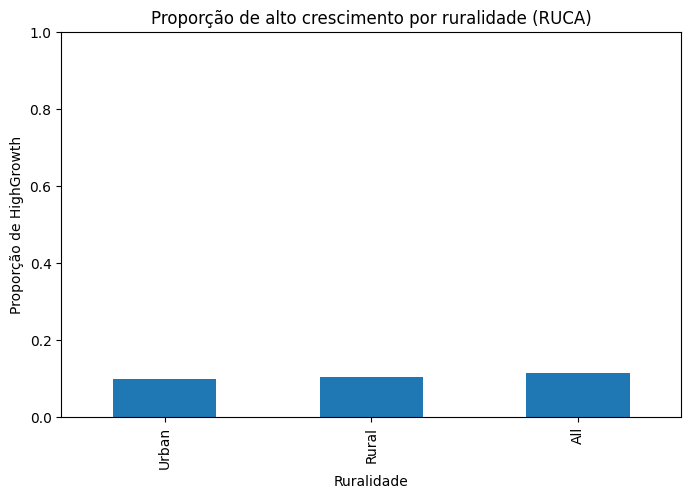

In [13]:
# Proporção de HighGrowth por ruralidade (RUCA)
if "Bene_RUCA_Desc" in df_model.columns:
    growth_by_ruca = df_model.groupby("Bene_RUCA_Desc")["HighGrowth"].mean().sort_values()

    plt.figure(figsize=(8, 5))
    growth_by_ruca.plot(kind="bar")
    plt.title("Proporção de alto crescimento por ruralidade (RUCA)")
    plt.ylabel("Proporção de HighGrowth")
    plt.xlabel("Ruralidade")
    plt.ylim(0, 1)
    plt.show()

    growth_by_ruca

### 5.1. Comentários sobre a EDA

Os gráficos e tabelas acima permitem discutir:

- **Distribuição de `Delta_Telehealth`**: em geral, a maioria dos grupos apresenta variações
  relativamente pequenas entre trimestres, enquanto poucos pontos exibem aumentos muito grandes.
  Isso reforça a importância de ter uma definição objetiva de "alto crescimento"
  (neste caso, o percentil 75 dos deltas positivos).

- **Proporção de `HighGrowth` ao longo do tempo**: é possível observar em quais anos há maior
  concentração de grupos com forte crescimento — por exemplo, em anos de choque externo
  (como pandemia) ou em momentos de expansão de infraestrutura digital.

- **Diferenças por faixa etária, raça e ruralidade**: alguns perfis podem apresentar
  maior probabilidade de alto crescimento, indicando **populações em rápida adoção
  de serviços digitais de saúde**. Essas informações serão importantes na discussão
  de como usar o modelo para orientar novas funcionalidades no aplicativo de HealthTech.


## 6. Formulação do problema de Machine Learning

Com base na variável binária `HighGrowth`, formulamos um problema de **classificação binária**:

- **Entrada (features)**: combinação de características regionais e demográficas, além do nível anterior
  de uso de telemedicina (`Prev_Pct_Telehealth`) e volumes de beneficiários.
- **Saída (target)**: indicador se o grupo apresentou **alto crescimento** (`HighGrowth = 1`)
  ou não (`HighGrowth = 0`).

O objetivo é treinar um modelo capaz de, dado o perfil de uma região/demografia em um trimestre,
estimar a probabilidade de que essa combinação apresente um crescimento expressivo em relação ao trimestre anterior.

As features utilizadas são:

- Geografia: `Bene_Geo_Desc`  
- Tempo: `Year`, `quarter`  
- Demografia: `Bene_Race_Desc`, `Bene_Sex_Desc`, `Bene_Age_Desc`  
- Status de elegibilidade e inscrição: `Bene_Mdcd_Mdcr_Enrl_Stus`, `Bene_Mdcr_Entlmt_Stus`  
- Ruralidade: `Bene_RUCA_Desc`  
- Níveis e volumes de beneficiários: `Total_Bene_TH_Elig`, `Total_PartB_Enrl`  
- Nível anterior de uso: `Prev_Pct_Telehealth`


In [14]:
feature_cols = [
    "Bene_Geo_Desc",
    "Year",
    "quarter",
    "Bene_Race_Desc",
    "Bene_Sex_Desc",
    "Bene_Age_Desc",
    "Bene_RUCA_Desc",
    "Bene_Mdcd_Mdcr_Enrl_Stus",
    "Bene_Mdcr_Entlmt_Stus",
    "Total_Bene_TH_Elig",
    "Total_PartB_Enrl",
    "Prev_Pct_Telehealth"
]

# Remover linhas com valores ausentes nas features ou no target
data_ml = df_model.dropna(subset=feature_cols + ["HighGrowth"]).copy()

X = data_ml[feature_cols]
y = data_ml["HighGrowth"]

# Identificar colunas categóricas e numéricas
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

cat_cols, num_cols

(['Bene_Geo_Desc',
  'quarter',
  'Bene_Race_Desc',
  'Bene_Sex_Desc',
  'Bene_Age_Desc',
  'Bene_RUCA_Desc',
  'Bene_Mdcd_Mdcr_Enrl_Stus',
  'Bene_Mdcr_Entlmt_Stus'],
 ['Year', 'Total_Bene_TH_Elig', 'Total_PartB_Enrl', 'Prev_Pct_Telehealth'])

In [15]:
# Divisão treino / teste com estratificação pela classe
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((15480, 12), (3870, 12))

## 7. Construção do modelo de classificação

Utilizamos um pipeline de Machine Learning composto por:

1. **Pré-processamento** via `ColumnTransformer`:
   - One-Hot Encoding para variáveis categóricas;
   - Padronização (`StandardScaler`) para variáveis numéricas.

2. **Modelo de classificação**: `RandomForestClassifier`, que é robusto para dados tabulares
   e lida bem com relações não lineares entre variáveis.

Além disso, como a classe `HighGrowth = 1` tende a ser minoritária, utilizamos o parâmetro
`class_weight='balanced'` para reduzir o impacto do desbalanceamento nas métricas.


In [16]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ]
)

clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", clf)
])

pipe.fit(X_train, y_train)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 8. Avaliação do modelo

Nesta etapa avaliamos o desempenho do classificador no conjunto de teste,
utilizando as métricas:

- **Acurácia (Accuracy)**: proporção de classificações corretas.  
- **Precisão (Precision)**: entre as previsões de alto crescimento, qual fração realmente é alto crescimento.  
- **Recall (Sensibilidade)**: entre todos os casos de alto crescimento, qual fração o modelo conseguiu identificar.  
- **F1-score**: média harmônica entre precisão e recall, útil em cenários desbalanceados.  
- **ROC-AUC**: capacidade do modelo em separar as duas classes ao longo de diferentes limiares.

Também analisamos a **matriz de confusão**, que permite visualizar onde ocorrem os erros
(falsos positivos e falsos negativos).


In [17]:
# Predições no conjunto de teste
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("Relatório de classificação:\n")
print(classification_report(y_test, y_pred))

print("ROC-AUC:", roc_auc_score(y_test, y_prob))

print("\nMatriz de confusão:")
print(confusion_matrix(y_test, y_pred))

Relatório de classificação:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3440
           1       0.95      0.83      0.89       430

    accuracy                           0.98      3870
   macro avg       0.97      0.91      0.94      3870
weighted avg       0.98      0.98      0.98      3870

ROC-AUC: 0.9866326392644672

Matriz de confusão:
[[3423   17]
 [  73  357]]


### 8.1. Importância das variáveis

Para interpretar melhor o modelo, analisamos a importância relativa das variáveis de entrada.
Isso nos ajuda a responder perguntas como:

- O **ano** e o **trimestre** influenciam fortemente o crescimento de telemedicina?  
- O nível anterior de uso (`Prev_Pct_Telehealth`) é determinante para prever novos saltos de crescimento?  
- Alguns estados, faixas etárias ou perfis demográficos aparecem com maior peso na probabilidade de alto crescimento?

A seguir extraímos e visualizamos as principais features segundo o Random Forest.


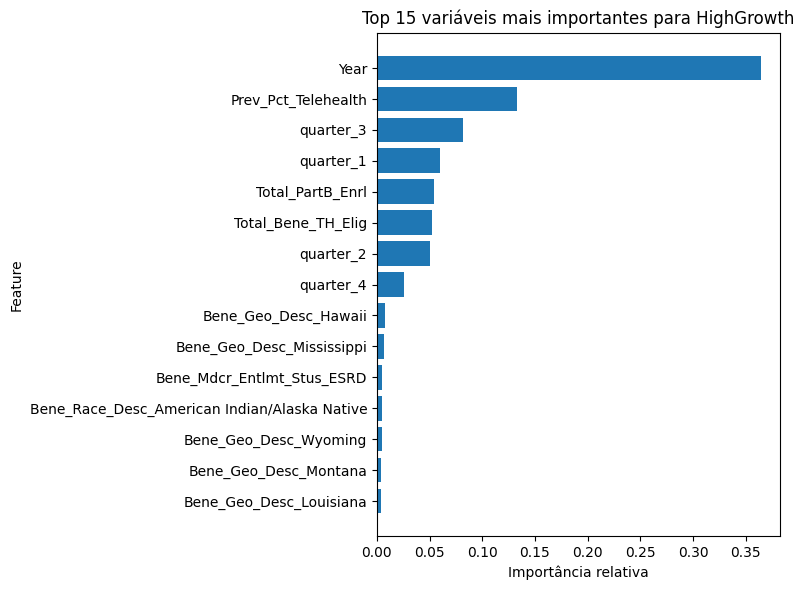

In [ ]:
# Extrair importâncias de variáveis a partir do modelo dentro do pipeline
rf_model = pipe.named_steps["model"]
ohe = pipe.named_steps["prep"].named_transformers_["cat"]

# Recuperar nomes das colunas após o One-Hot Encoding
cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
all_feature_names = cat_feature_names + num_cols

importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

feature_importances.head(15)

# Plot das 15 variáveis mais importantes
top_n = 15
top_feats = feature_importances.head(top_n).sort_values("importance")

plt.figure(figsize=(8, 6))
plt.barh(top_feats["feature"], top_feats["importance"])
plt.title(f"Top {top_n} variáveis mais importantes para HighGrowth")
plt.xlabel("Importância relativa")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## 9. Discussão e implicações para HealthTech

Os resultados obtidos permitem concluir que é **possível** prever, com bom desempenho,
quais combinações de características regionais e demográficas tendem a apresentar
**crescimento acentuado** no uso de telemedicina entre trimestres consecutivos.

Do ponto de vista de negócio, essas previsões podem ser usadas para:

- **Identificar populações em rápida adoção de ferramentas digitais de saúde**, que são candidatas
  ideais para receber novas funcionalidades em um aplicativo de HealthTech, como:
  - Programas de mudança de hábito (sono, alimentação, atividade física);
  - Desafios gamificados e metas semanais de bem-estar;
  - Trilhas de conteúdo educativo em saúde preventiva.

- **Reconhecer grupos com baixo crescimento**, nos quais pode ser necessário investir mais em:
  - Letramento digital em saúde (como usar ferramentas digitais de forma segura);
  - Comunicação clara sobre os benefícios de recursos remotos, sem necessariamente envolver teleconsulta;
  - Estratégias híbridas (online + offline) para aumentar confiança e engajamento.

Importante destacar que, embora o dataset trate de **telemedicina**, a aplicação final no app
não precisa (e, no contexto do desafio, **não deve**) envolver serviços de teleconsulta
ou diagnóstico. Em vez disso, os insights de crescimento digital podem orientar a oferta de
**serviços não clínicos** voltados à prevenção, bem-estar e qualidade de vida,
como acompanhamento de hábitos, conteúdos personalizados e ações de educação em saúde.

Assim, o modelo de Machine Learning funciona como um **motor de inteligência** capaz de direcionar
onde e para quem lançar novas iniciativas digitais, respeitando as restrições tecnológicas
e regulatórias do desafio.
